## Library

In [1]:
%matplotlib inline
import glob
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import seaborn as sns
from PIL import Image
from IPython.display import display
import cv2

# 셀에서 값을 연속적으로 모두 출력
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings(action='ignore')

## Create Dataframe

In [2]:
def create_data_frame(default_image_path:str,data_path:str,level_path:str,source_path:str):
    data = {}
    data['latex'] = []
    data['latex_str']=[]
    data['seq_len'] = []
    data['aspect_ratio'] = []
    data['image_width'] = []
    data['image_height'] = []
    data['level']=[]
    data['source']=[]
    data['img_name']=[]
    
    all_latex_list = []
    lv1_latex_list=[]
    lv2_latex_list=[]
    lv3_latex_list=[]
    lv4_latex_list=[]
    lv5_latex_list=[]
    
    with open(level_path) as f:
        level_info={}
        for line in f:
            path,level=line.replace("\n","").split("\t")
            level_info[path]=int(level)
            data['img_name'].append(path)
            
            
    with open(source_path) as f:
        source_info={}
        for line in f:
            path,source=line.replace("\n","").split("\t")
            source_info[path]=str(source)
            
    with open(data_path) as f:
        for idx,line in enumerate(f):
            image_path,latex=line.replace("\n","").split("\t")
            image = Image.open(default_image_path+image_path)
            width, height = image.size
            data['aspect_ratio'].append(round(width / height,1))
            data['image_width'].append(int(width))
            data['image_height'].append(int(height))
            data['latex_str'].append(latex)
            latex=latex.split(" ")
            data['latex'].append(latex)
            data['seq_len'].append(len(latex))
            level=level_info[image_path]
            data['level'].append(level)
            source=source_info[image_path]
            data['source'].append(source)
            all_latex_list += latex
            if level==1:
                lv1_latex_list += latex
            elif level==2:
                lv2_latex_list += latex
            elif level==3:
                lv3_latex_list += latex
            elif level==4:
                lv4_latex_list += latex
            else:
                lv5_latex_list += latex

    df = pd.DataFrame.from_dict(data)
    lv_latex_list=[lv1_latex_list,lv2_latex_list,lv3_latex_list,lv4_latex_list,lv5_latex_list]
    
    return df, all_latex_list, lv_latex_list

In [3]:
default_image_path="/opt/ml/input/data/images/"
data_path="/opt/ml/input/data/gt.txt"
level_path="/opt/ml/input/data/level.txt"
source_path="/opt/ml/input/data/source.txt"

df, all_latex_list, lv_latex_list = create_data_frame(default_image_path, data_path, level_path, source_path)

In [4]:
df.columns.to_list()
df.head()
df.describe()

['latex',
 'latex_str',
 'seq_len',
 'aspect_ratio',
 'image_width',
 'image_height',
 'level',
 'source',
 'img_name']

,latex,latex_str,seq_len,aspect_ratio,image_width,image_height,level,source,img_name
0,"[4, \times, 7, =, 2, 8]",4 \times 7 = 2 8,6,4.2,903,213,1,1,train_00000.jpg
1,"[a, ^, {, x, }, >, q]",a ^ { x } > q,7,3.7,435,118,2,0,train_00001.jpg
2,"[8, \times, 9]",8 \times 9,3,2.0,348,172,2,0,train_00002.jpg
3,"[\sum, _, {, k, =, 1, }, ^, {, n, -, 1, }, b, ...",\sum _ { k = 1 } ^ { n - 1 } b _ { k } = a _ {...,30,3.2,964,299,3,1,train_00003.jpg
4,"[I, =, d, q, /, d, t]",I = d q / d t,7,3.4,700,208,4,0,train_00004.jpg


,seq_len,aspect_ratio,image_width,image_height,level
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,17.536930,4.344388,1309.317910,333.098100,2.392250
std,14.952702,2.484526,1120.911322,312.306097,0.845575
min,1.000000,0.100000,35.000000,20.000000,1.000000
25%,7.000000,2.600000,563.000000,173.000000,2.000000
50%,13.000000,3.800000,1012.000000,255.000000,2.000000
75%,23.000000,5.500000,1732.000000,393.000000,3.000000
max,252.000000,33.900000,11810.000000,10020.000000,5.000000


In [5]:
df[df['level']==1].iloc[0]['img_name']
df[df['level']==2].iloc[0]['img_name']
df[df['level']==3].iloc[0]['img_name']
df[df['level']==4].iloc[0]['img_name']
df[df['level']==5].iloc[0]['img_name']

'train_00000.jpg'

'train_00001.jpg'

'train_00003.jpg'

'train_00004.jpg'

'train_00340.jpg'

## Print latex_to_img & origin_img

In [6]:
def latex_to_img(img_num:int):
    level_color=[
        'turquoise',
        'lightgreen',
        'gold',
        'sandybrown',
        'salmon'
    ]
    
    box1 = {'boxstyle': 'round',
        'ec': (0.1, 0.1, 0.1), # edgecolor
        'fc': level_color[int(df.iloc[img_num]['level'])-1]} # (0.5, 0.8, 0.8)} # facecolor
    
    a = df.iloc[img_num]['latex_str']
    ax = plt.axes([0,0,0.2,0.2]) #left,bottom,width,height
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
    plt.text(0.3,0.5,'$%s$' %a, size=30, bbox=box1)
    plt.show()

In [7]:
def origin_img(img_num:int):
    img_name = df.iloc[img_num]['img_name']
    img = mpimg.imread(default_image_path+img_name)
    plt.grid(True, color='w')
    plt.imshow(img)
    plt.show()

In [8]:
def compare_img_gt(img_num:int, visible_infos=False):
    img_name = df.iloc[img_num]['img_name']
    img = mpimg.imread(default_image_path+img_name)
    plt.grid(True, color='w')
    plt.imshow(img)
    plt.show()
    
    level_color=[
        'turquoise',
        'lightgreen',
        'gold',
        'sandybrown',
        'salmon'
    ]
    
    box1 = {'boxstyle': 'round',
        'ec': (0.1, 0.1, 0.1), # edgecolor
        'fc': level_color[int(df.iloc[img_num]['level'])-1]} # (0.5, 0.8, 0.8)} # facecolor
    
    # ground truth latex to img
    a = df.iloc[img_num]['latex_str']
    ax = plt.axes([0,0,0.2,0.2]) #left,bottom,width,height
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
    plt.text(0.3,0.5,'$%s$' %a,size=20, bbox=box1)
    plt.show()
    
    if visible_infos:
        display(df.iloc[img_num][1:])

====================== print all ========================== 


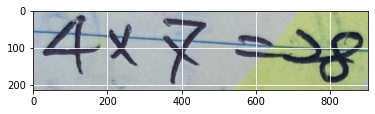

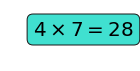

latex_str       4 \times 7 = 2 8
seq_len                        6
aspect_ratio                 4.2
image_width                  903
image_height                 213
level                          1
source                         1
img_name         train_00000.jpg
Name: 0, dtype: object

In [9]:
# print("==================== print latex to img ==================== ")
# latex_to_img(img_num=0)

# print("===================== print origin img ==================== ")
# origin_img(img_num=0)

print("====================== print all ========================== ")
compare_img_gt(img_num=0, visible_infos=True)

## Level에 따른 LaTeX background 색 변경

In [10]:
# level_testset = []
# level_testset.append(df[df['level']==1].iloc[0]['img_name'])
# level_testset.append(df[df['level']==2].iloc[0]['img_name'])
# level_testset.append(df[df['level']==3].iloc[0]['img_name'])
# level_testset.append(df[df['level']==4].iloc[0]['img_name'])
# level_testset.append(df[df['level']==5].iloc[0]['img_name'])

# level_testset

# for name in level_testset:
#     ind = int(name.split('_')[1].split('.')[0])
#     compare_img_gt(img_num=ind, visible_infos=True)

## Resolution correlation

## Plot display

In [33]:
def plot_dist(df, field, bins, color, xlabel, ylabel, title):
    sns.set(color_codes=True)
    fig, ax = plt.subplots(figsize=(8,4))
    sns.distplot(df[field], bins=bins, color=color, ax=ax)
    ax.set_xlabel(xlabel, fontsize=13)
    ax.set_ylabel(ylabel, fontsize=13)
    ax.set_title(title, fontsize=16)
    plt.show()

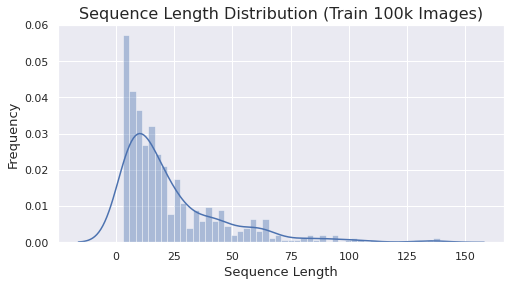

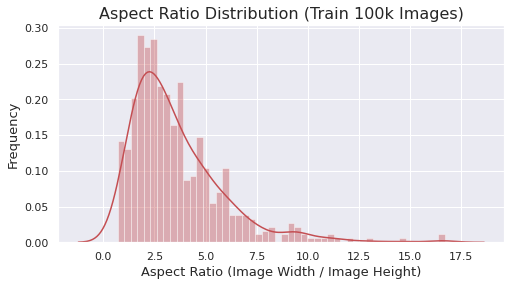

In [35]:
plot_dist(df=df, field='seq_len', bins=50, color='b', xlabel='Sequence Length', \
          ylabel='Frequency', title='Sequence Length Distribution (Train 100k Images)')

plot_dist(df=df, field='aspect_ratio', bins=50, color='r', xlabel='Aspect Ratio (Image Width / Image Height)', \
          ylabel='Frequency', title='Aspect Ratio Distribution (Train 100k Images)')

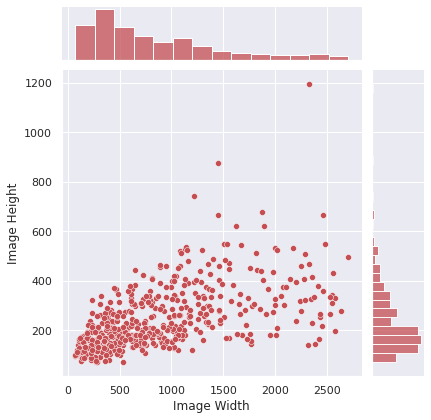

In [37]:
g = sns.jointplot("image_width", "image_height", data=df, color="r")
g.set_axis_labels("Image Width", "Image Height")

In [ ]:
# def create_count_df(df, field, index,top_token):
#     count=df.groupby(field)[index].count().sort_values(ascending=False)
#     count_df = count.to_frame().reset_index()
#     count_df.columns = [field, field + '_count']
#     return count_df[:top_token]

# def plot_count_df(df, field, random_sample, color, rotation, xlabel, ylabel, title):
#     fig, ax = plt.subplots(figsize=(10,4))
#     if random_sample:
#         df = df.sample(n=50, random_state=1)
#     ax.bar(df[field], df[field + '_count'], color=color, align='center',alpha=0.5)
#     ax.set_xticklabels(df[field],rotation=rotation, fontsize=13)
#     ax.set_xlabel(xlabel, fontsize=13)
#     ax.set_ylabel(ylabel, fontsize=13)
#     ax.set_title(title, fontsize=16)
#     plt.show()

In [ ]:
# token_df = pd.DataFrame(all_latex_list, columns =['token'])
# token_df['index']=token_df.index

In [ ]:
# token_count_df = create_count_df(df=token_df, field='token', index='index',top_token=20)
# plot_count_df(df=token_count_df, field='token', random_sample=False, color='g', rotation=90, xlabel='Token', \
#               ylabel='Number of Tokens', title='Token Distribution (10k Images)')

In [ ]:
# level_1 = df[df['level'] == 1]
# level_2 = df[df['level'] == 2]
# level_3 = df[df['level'] == 3]
# level_4 = df[df['level'] == 4]
# level_5 = df[df['level'] == 5]
# level_dfs=[level_1,level_2,level_3,level_4,level_5]

In [ ]:
# for level,df in enumerate(level_dfs):
#     plot_dist(df=df, field='seq_len', bins=50, color='b', xlabel='Sequence Length', \
#           ylabel='Frequency', title='Sequence Length Distribution (level {})'.format(level+1))
#     plot_dist(df=df, field='aspect_ratio', bins=10, color='r', xlabel='Aspect Ratio (Image Width / Image Height)', \
#           ylabel='Frequency', title='Aspect Ratio Distribution (level {})'.format(level+1))
    
#     g = sns.jointplot("image_width", "image_height", data=df, kind="kde", space=0, color="r")
#     g.set_axis_labels("Image Width", "Image Height")
#     token_df = pd.DataFrame(lv_latex_list[level], columns =['token'])
#     token_df['index']=token_df.index
#     token_count_df = create_count_df(df=token_df, field='token', index='index',top_token=20)
#     plot_count_df(df=token_count_df, field='token', random_sample=False, color='g', rotation=90, xlabel='Token', \
#               ylabel='Number of Tokens', title='Token Distribution (level {})'.format(level+1))
    

In [ ]:
# level=0
# level_dfs[level].describe()

In [ ]:
# plot_dist(df=level_dfs[level], field='seq_len', bins=50, color='b', xlabel='Sequence Length', \
#       ylabel='Frequency', title='Sequence Length Distribution (level {})'.format(level+1))
# plot_dist(df=level_dfs[level], field='aspect_ratio', bins=10, color='r', xlabel='Aspect Ratio (Image Width / Image Height)', \
#       ylabel='Frequency', title='Aspect Ratio Distribution (level {})'.format(level+1))
# g = sns.jointplot("image_width", "image_height", data=level_dfs[level], kind="kde", space=0, color="r")
# g.set_axis_labels("Image Width", "Image Height")
# token_df = pd.DataFrame(lv_latex_list[level], columns =['token'])
# token_df['index']=token_df.index
# token_count_df = create_count_df(df=token_df, field='token', index='index',top_token=20)
# plot_count_df(df=token_count_df, field='token', random_sample=False, color='g', rotation=90, xlabel='Token', \
#           ylabel='Number of Tokens', title='Token Distribution (level {})'.format(level+1))

In [ ]:
# level=1
# level_dfs[level].describe()

In [ ]:
# plot_dist(df=level_dfs[level], field='seq_len', bins=50, color='b', xlabel='Sequence Length', \
#       ylabel='Frequency', title='Sequence Length Distribution (level {})'.format(level+1))
# plot_dist(df=level_dfs[level], field='aspect_ratio', bins=10, color='r', xlabel='Aspect Ratio (Image Width / Image Height)', \
#       ylabel='Frequency', title='Aspect Ratio Distribution (level {})'.format(level+1))
# g = sns.jointplot("image_width", "image_height", data=level_dfs[level], kind="kde", space=0, color="r")
# g.set_axis_labels("Image Width", "Image Height")
# token_df = pd.DataFrame(lv_latex_list[level], columns =['token'])
# token_df['index']=token_df.index
# token_count_df = create_count_df(df=token_df, field='token', index='index',top_token=20)
# plot_count_df(df=token_count_df, field='token', random_sample=False, color='g', rotation=90, xlabel='Token', \
#           ylabel='Number of Tokens', title='Token Distribution (level {})'.format(level+1))

In [ ]:
# level=2
# level_dfs[level].describe()

In [ ]:
# plot_dist(df=level_dfs[level], field='seq_len', bins=50, color='b', xlabel='Sequence Length', \
#       ylabel='Frequency', title='Sequence Length Distribution (level {})'.format(level+1))
# plot_dist(df=level_dfs[level], field='aspect_ratio', bins=10, color='r', xlabel='Aspect Ratio (Image Width / Image Height)', \
#       ylabel='Frequency', title='Aspect Ratio Distribution (level {})'.format(level+1))
# g = sns.jointplot("image_width", "image_height", data=level_dfs[level], kind="kde", space=0, color="r")
# g.set_axis_labels("Image Width", "Image Height")
# token_df = pd.DataFrame(lv_latex_list[level], columns =['token'])
# token_df['index']=token_df.index
# token_count_df = create_count_df(df=token_df, field='token', index='index',top_token=20)
# plot_count_df(df=token_count_df, field='token', random_sample=False, color='g', rotation=90, xlabel='Token', \
#           ylabel='Number of Tokens', title='Token Distribution (level {})'.format(level+1))

In [ ]:
# level=3
# level_dfs[level].describe()

In [ ]:
# plot_dist(df=level_dfs[level], field='seq_len', bins=50, color='b', xlabel='Sequence Length', \
#       ylabel='Frequency', title='Sequence Length Distribution (level {})'.format(level+1))
# plot_dist(df=level_dfs[level], field='aspect_ratio', bins=10, color='r', xlabel='Aspect Ratio (Image Width / Image Height)', \
#       ylabel='Frequency', title='Aspect Ratio Distribution (level {})'.format(level+1))
# g = sns.jointplot("image_width", "image_height", data=level_dfs[level], kind="kde", space=0, color="r")
# g.set_axis_labels("Image Width", "Image Height")
# token_df = pd.DataFrame(lv_latex_list[level], columns =['token'])
# token_df['index']=token_df.index
# token_count_df = create_count_df(df=token_df, field='token', index='index',top_token=20)
# plot_count_df(df=token_count_df, field='token', random_sample=False, color='g', rotation=90, xlabel='Token', \
#           ylabel='Number of Tokens', title='Token Distribution (level {})'.format(level+1))

In [ ]:
# level=4
# level_dfs[level].describe()

In [ ]:
# plot_dist(df=level_dfs[level], field='seq_len', bins=50, color='b', xlabel='Sequence Length', \
#       ylabel='Frequency', title='Sequence Length Distribution (level {})'.format(level+1))
# plot_dist(df=level_dfs[level], field='aspect_ratio', bins=10, color='r', xlabel='Aspect Ratio (Image Width / Image Height)', \
#       ylabel='Frequency', title='Aspect Ratio Distribution (level {})'.format(level+1))
# g = sns.jointplot("image_width", "image_height", data=level_dfs[level], kind="kde", space=0, color="r")
# g.set_axis_labels("Image Width", "Image Height")
# token_df = pd.DataFrame(lv_latex_list[level], columns =['token'])
# token_df['index']=token_df.index
# token_count_df = create_count_df(df=token_df, field='token', index='index',top_token=20)
# plot_count_df(df=token_count_df, field='token', random_sample=False, color='g', rotation=90, xlabel='Token', \
#           ylabel='Number of Tokens', title='Token Distribution (level {})'.format(level+1))